<a href="https://colab.research.google.com/github/nameonwoo/math/blob/main/ch09_multi_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9장 로지스틱 회귀 모델(다중 클래스 분류)

In [ ]:
# 필요 라이브러리 선언
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# PDF 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

<ipython-input-20-324a830845c1>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


### 데이터 준비

In [ ]:
# 학습용 데이터 준비
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 입력 데이터에 관해서는 sepal length(0)와 petal length(2)만을 추출
x_select = x_org[:,[0,2]]
print('원래 데이터', x_select.shape, y_org.shape)

원래 데이터 (150, 2) (150,)


<----세 종류의 붓꽃  50개씩 150개에 대하여 꽃받침 길이와 꽃잎 길이 두항목을 사용

### 학습 데이터의 산점도 표시

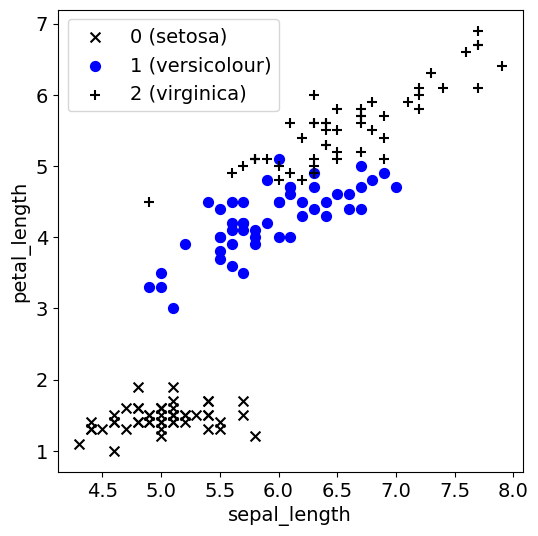

In [ ]:
# 산점도 표시
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

<----class1과 class2사이의 경계부분이 좀 겹치긴 하지만 꽃받침의 길이와 꽃잎의 길이 2개의 변수만으로도 분류가능한 걸 삼점도를 통해 알 수 있다

### 데이터 전처리

In [ ]:
# 더미 변수를 추가
x_all = np.insert(x_select, 0, 1.0, axis=1)

<----벡터차원을 맞추기 위해 더미변수를 추가

In [ ]:
# y의 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, categories='auto')
y_work = np.c_[y_org]
y_all_one = ohe.fit_transform(y_work)
print('오리지널', y_org.shape)
print('2차원화', y_work.shape)
print('원핫 인코딩', y_all_one.shape)

오리지널 (150,)
2차원화 (150, 1)
원핫 인코딩 (150, 3)


<----모델의 출력값이 세가지이므로 이진분류를 이용할 수 없고 1대다 분류기를 이용하여 0과 1로만 구성된 3차원벡터 즉 원핫벡터로 변환하는 과정

In [ ]:
# 학습 데이터와 검증 데이터를 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,
    y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


<----과적합(overfitting)을 방지하고 성능을 평가하여 최적화와 하이퍼파라미터 튜닝을 위해 학습데아터와 검중데이터로 분할하는데 여기서는 75개씩으로 분할

In [ ]:
print('입력 데이터(x)')
print(x_train[:5,:])

입력 데이터(x)
[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]


<----데이터의 일부내용을 프린트

In [ ]:
print('정답값(y)')
print(y_train[:5])

정답값(y)
[1 1 0 2 2]


<----위 출력 입력 데이터에 대한 클래스 정답

In [ ]:
print('정답값(원핫 인코딩)')
print(y_train_one[:5,:])

정답값(원핫 인코딩)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


<----위 정답값 0, 1, 2를 원핫 인코딩을 통해 0과 1의 값만갖는 3차원벡터로 변환

### 학습용 변수 설정

In [ ]:
# 학습 대상의 선택
x, yt = x_train, y_train_one

### 예측함수

In [ ]:
# 소프트맥스 함수 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

<----1. 오버플로를 막기 위해 지수함수를 호출하기전에 데이터의 최댔값을 빼고 소프트맥스함수를 구현
2. 여러개의 데이터계열을 하번에 다룰 때는 행렬을 사용하는데 이를 위해 입력데이터를 전치시키고 마지막에 다시 전치시킨다

In [ ]:
# 예측값 계산 (9.7.1), (9.7.2)
def pred(x, W):
    return softmax(x @ W)

<----예측값을 계산하는 pred함수를 구현
     입력데이터와 가중치행렬의 곱셈에 softmax함수를 적용해 모두 합하면 1이되는 0과 1사이의, 확률값으로 해석할수 있는 예측값을 출력

### 평가

In [ ]:
# 교차 엔트로피 함수 (9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

<----손실함수로 교차엔트로피 함수 이용

In [ ]:
# 모델을 평가하는 함수
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):

    # 예측값 계산(확률값)
    yp_test_one = pred(x_test, W)

    # 확률값에서 예측 클래스(0, 1, 2)를 도출
    yp_test = np.argmax(yp_test_one, axis=1)

    # 손실함수 값 계산
    loss = cross_entropy(y_test_one, yp_test_one)

    # 정확도 산출
    score = accuracy_score(y_test, yp_test)
    return loss, score

<---검증데이터로 예측값을 계산하고 cross_entropy함수로 손실함수의 값을 계산하고 sklearn의 accuracy_score 함수로 정확도를 계산한다

### 초기화 처리

In [ ]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N))

# 평가 결과 기록
history = np.zeros((0, 3))

### 주요 처리

In [ ]:
# 주요 처리
for k in range(iters):

    # 예측값 계산 (9.7.1), (9.7.2)
    yp = pred(x, W)

    # 오차 계산 (9.7.4)
    yd = yp - yt

    # 가중치 업데이트 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f"
            % (k, loss, score))

epoch = 0 loss = 1.092628 score = 0.266667
epoch = 10 loss = 1.064035 score = 0.266667
epoch = 20 loss = 1.033466 score = 0.266667
epoch = 30 loss = 1.002645 score = 0.266667
epoch = 40 loss = 0.973510 score = 0.266667
epoch = 50 loss = 0.946309 score = 0.386667
epoch = 60 loss = 0.920978 score = 0.560000
epoch = 70 loss = 0.897402 score = 0.600000
epoch = 80 loss = 0.875452 score = 0.613333
epoch = 90 loss = 0.855005 score = 0.626667
epoch = 100 loss = 0.835942 score = 0.626667
epoch = 110 loss = 0.818152 score = 0.626667
epoch = 120 loss = 0.801532 score = 0.626667
epoch = 130 loss = 0.785986 score = 0.626667
epoch = 140 loss = 0.771424 score = 0.640000
epoch = 150 loss = 0.757767 score = 0.653333
epoch = 160 loss = 0.744941 score = 0.680000
epoch = 170 loss = 0.732877 score = 0.706667
epoch = 180 loss = 0.721513 score = 0.760000
epoch = 190 loss = 0.710795 score = 0.786667
epoch = 200 loss = 0.700670 score = 0.786667
epoch = 210 loss = 0.691092 score = 0.800000
epoch = 220 loss = 0.

### 결과 확인

In [ ]:
# 손실함수의 값과 정확도 점검
print ( '[초기 상태] 손실함수: %f, 정확도: %f'
    % (history[0,1], history[0,2]))
print( '[최종 상태] 손실함수: %f, 정확도: %f'
    % (history[-1,1], history[-1,2]))

[초기 상태] 손실함수: 1.092628, 정확도: 0.266667
[최종 상태] 손실함수: 0.197948, 정확도: 0.960000


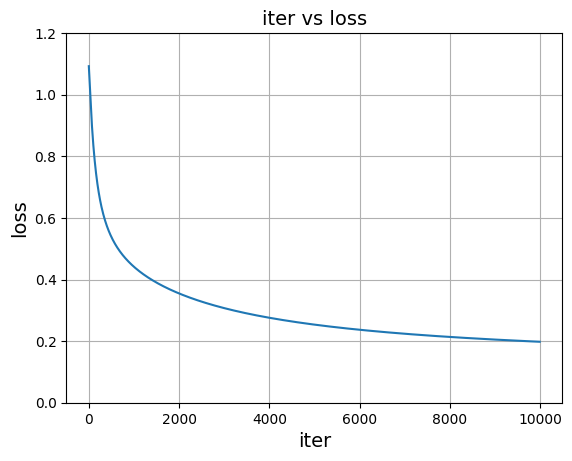

In [ ]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

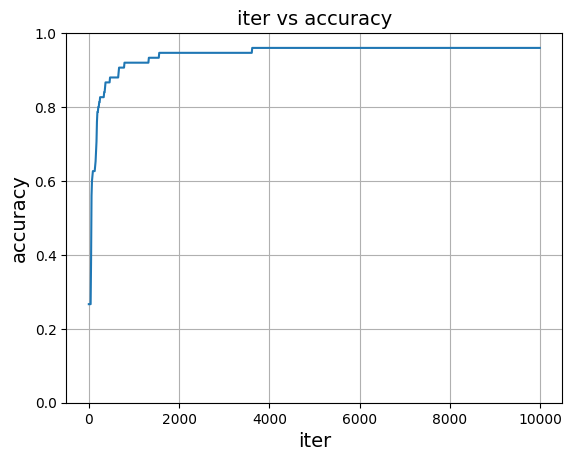

In [ ]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

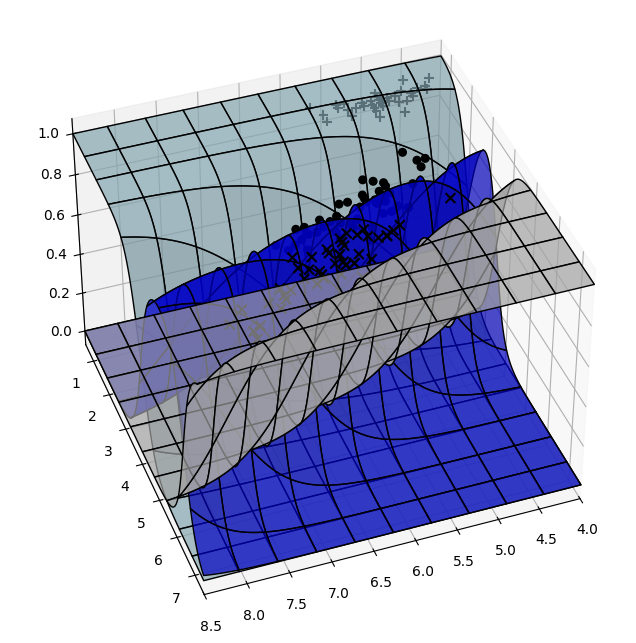

In [ ]:
# 3차원 표시
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

In [ ]:
# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 테스트 데이터로 예측값 계산
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 혼동행렬의 표시
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.960000
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



# 입력 변수를 4차원으로 변경

In [ ]:
# 더미 변수를 추가
x_all2 = np.insert(x_org, 0, 1.0, axis=1)

In [ ]:
# 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75,
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape,
    y_train.shape, y_test.shape,
    y_train_one.shape, y_test_one.shape)

(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


In [ ]:
print('입력 데이터(x)')
print(x_train2[:5,:])

입력 데이터(x)
[[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


In [ ]:
# 학습 대상의 선택
x, yt, x_test = x_train2, y_train_one, x_test2

In [ ]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N))

# 평가 결과 기록
history = np.zeros((0, 3))

In [ ]:
# 주요 처리(4차원 버전)
for k in range(iters):

    # 예측값 계산 (9.7.1), (9.7.2)
    yp = pred(x, W)

    # 오차 계산 (9.7.4)
    yd = yp - yt

    # 가중치 업데이트 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

epoch = 0 loss = 1.091583 score = 0.266667
epoch = 10 loss = 1.041711 score = 0.266667
epoch = 20 loss = 0.988501 score = 0.266667
epoch = 30 loss = 0.939962 score = 0.573333
epoch = 40 loss = 0.897037 score = 0.626667
epoch = 50 loss = 0.859177 score = 0.626667
epoch = 60 loss = 0.825724 score = 0.626667
epoch = 70 loss = 0.796070 score = 0.626667
epoch = 80 loss = 0.769683 score = 0.653333
epoch = 90 loss = 0.746103 score = 0.653333
epoch = 100 loss = 0.724936 score = 0.693333
epoch = 110 loss = 0.705850 score = 0.746667
epoch = 120 loss = 0.688561 score = 0.760000
epoch = 130 loss = 0.672832 score = 0.760000
epoch = 140 loss = 0.658461 score = 0.786667
epoch = 150 loss = 0.645275 score = 0.786667
epoch = 160 loss = 0.633131 score = 0.786667
epoch = 170 loss = 0.621903 score = 0.813333
epoch = 180 loss = 0.611485 score = 0.813333
epoch = 190 loss = 0.601788 score = 0.840000
epoch = 200 loss = 0.592731 score = 0.840000
epoch = 210 loss = 0.584248 score = 0.880000
epoch = 220 loss = 0.

In [ ]:
print(history.shape)

(1000, 3)


In [ ]:
# 손실함수의 값과 정확도 점검
print ( '[초기 상태] 손실함수: %f, 정확도: %f'
    % (history[0,1], history[0,2]))
print( '[최종 상태] 손실함수: %f, 정확도: %f'
    % (history[-1,1], history[-1,2]))

[초기 상태] 손실함수: 1.091583, 정확도: 0.266667
[최종 상태] 손실함수: 0.137235, 정확도: 0.960000


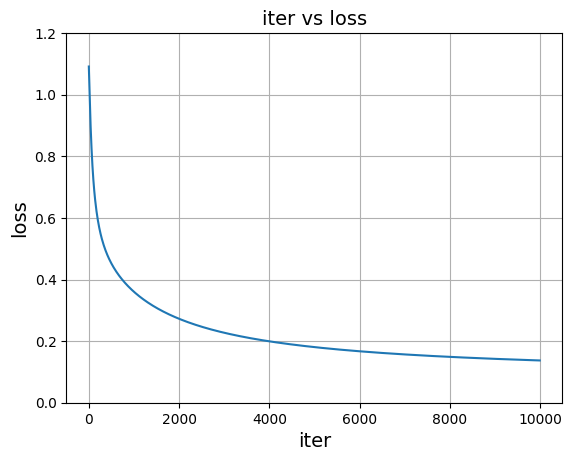

In [ ]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

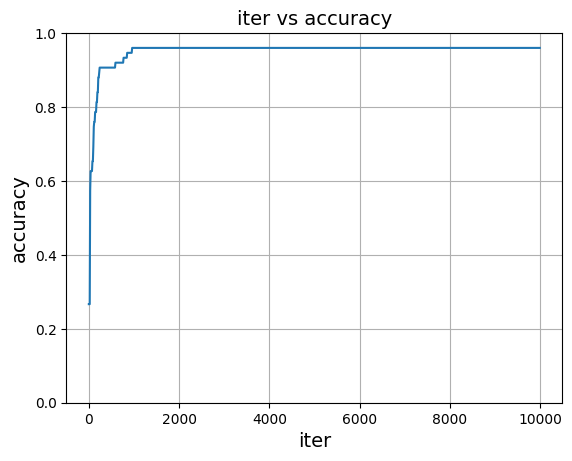

In [ ]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()